# Classificação de incêndios florestais utilizando redes neurais convolucionais profundas e Transfer Learning 

<center><img src='https://media4.giphy.com/media/QKUx6kHItu3ilaVMdn/200.webp?cid=ecf05e47gics2m4k7lfvntuuwai9q63i175fusn61o163gvy&rid=200.webp&ct=s' height=300px width=300px></center>

O problema abordado é o de classificação de incêndios florestais, no qual nossa base de dados apresenta imagens de florestas com e sem fogo nelas de resolução 250x250.
A tarefa é relativamente simples, o modelo deve retornar se em uma dada imagem aparece um incêndio, ou não.

O modelo utilizado foi retirado de uma submissão do Kaggle para um problema idêntico ao nosso, mas com outra base de dados. O link para tal submissão é: 
https://www.kaggle.com/code/vencerlanz09/98-fire-classification-cnn-mobilenetv2/notebook



# 🏗️ Import Necessary Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from pathlib import Path
import os.path

import pickle

import itertools

from tqdm.notebook import tqdm

# 📊 Auxiliar Functions

In [46]:
def create_images_dataframe(path):
    # Get filepaths and labels
    filepaths = list(path.glob(r'**/*.JPG')) + list(path.glob(r'**/*.jpg')) + list(path.glob(r'**/*.png'))
    
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
    
    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    return pd.concat([filepaths, labels], axis=1)

In [3]:
def map_to_label(y, labels):
    return [labels[p] for p in y]

In [4]:
def make_predictions(model, generator):
    X = []
    y_true = []

    for i in range(len(generator)):
        data, label = generator[i]
        
        X.extend(data)
        y_true.extend(label)
    
    print("Making predictions...")
    
    y_pred = np.argmax(model.predict(np.array(X)), axis=1)
    y_true = np.argmax(y_true, axis=1)
    
    return (X, y_pred, y_true)

In [5]:
def plot_history(hist):
    fig = plt.figure(figsize=(10, 4))

    fig.suptitle("Training History")
    
    # Plot loss
    fig.add_subplot(1, 2, 1)
    plt.plot(hist.history['loss'], label='training_loss')
    plt.plot(hist.history['val_loss'], label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    fig.add_subplot(1, 2, 2)
    plt.plot(hist.history['accuracy'], label='training_accuracy')
    plt.plot(hist.history['val_accuracy'], label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    
    plt.show()

In [6]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
    """
    Makes a labelled confusion matrix comparing predictions and ground truth labels.

    If classes is passed, confusion matrix will be labelled, if not, integer class values
    will be used.

    Args:
        y_true: Array of truth labels (must be same shape as y_pred).
        y_pred: Array of predicted labels (must be same shape as y_true).
        classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
        figsize: Size of output figure (default=(10, 10)).
        text_size: Size of output figure text (default=15).
        norm: normalize values or not (default=False).
        savefig: save confusion matrix to file (default=False).

    Returns:
        A labelled confusion matrix plot comparing y_true and y_pred.

    Example usage:
        make_confusion_matrix(y_true=test_labels, # ground truth test labels
        y_pred=y_preds, # predicted labels
        classes=class_names, # array of class label names
        figsize=(15, 15),
        text_size=10)
    """  
    # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    # Label the axes
    ax.set(title="Confusion Matrix",
    xlabel="Predicted label",
    ylabel="True label",
    xticks=np.arange(n_classes), # create enough axis slots for each class
    yticks=np.arange(n_classes), 
    xticklabels=labels, # axes will labeled with class names (if they exist) or ints
    yticklabels=labels)

    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    # Set the threshold for different colors
    threshold = (cm.max() 
                 + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
            horizontalalignment="center",
            color="white" if cm[i, j] > threshold else "black",
            size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
            horizontalalignment="center",
            color="white" if cm[i, j] > threshold else "black",
            size=text_size)

    # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")

# 📥 Load and Transform Data

The first column `filepaths` contains the file path location of each individual images. The second column `labels`, on the other hand, contains the class label of the corresponding image from the file path

In [7]:
dataset_path = Path("../dataset/training-and-validation")

In [8]:
image_df = create_images_dataframe(dataset_path)

image_df.head()

Filepath Label
0  ..\dataset\training-and-validation\fire\fire_0...  fire
1  ..\dataset\training-and-validation\fire\fire_0...  fire
2  ..\dataset\training-and-validation\fire\fire_0...  fire
3  ..\dataset\training-and-validation\fire\fire_0...  fire
4  ..\dataset\training-and-validation\fire\fire_0...  fire

In [9]:
labels = { 0: 'fire', 1: 'nofire' }

# 🔭 Visualizing images from the dataset

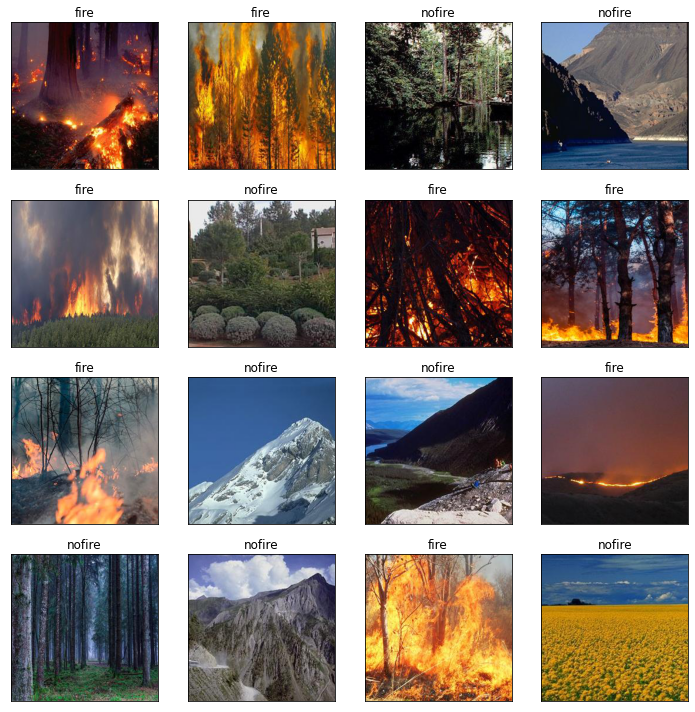

In [10]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)

fig, axes = plt.subplots(
    nrows=4, 
    ncols=4, 
    figsize=(10, 10),
    subplot_kw={'xticks': [], 'yticks': []}
)

for i, ax in enumerate(axes.flat):
    image = Image.open(image_df.Filepath[random_index[i]])
    ax.imshow(image)
    ax.set_title(image_df.Label[random_index[i]])
    
plt.tight_layout()
plt.show()

# 📝 Data Preprocessing
The data will be split into two different categories: Training and Validation. The training data will be used to train the deep learning CNN model and its parameters will be fine tuned with the validation data.

In [11]:
BATCH_SIZE = 32

In [12]:
# shuffles dataframe rows

image_df = image_df.sample(frac=1).reset_index(drop=True)

In [13]:
train_image_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.3,
    rotation_range=90,
    horizontal_flip=True
)

In [14]:
train_images = train_image_generator.flow_from_dataframe(
    dataframe=image_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    rescale=1./255,
    color_mode='rgb',
    shuffle=True,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    subset='training'
)

val_images = train_image_generator.flow_from_dataframe(
    dataframe=image_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    rescale=1./255,
    color_mode='rgb',
    shuffle=True,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    subset='validation'
)

Found 2128 validated image filenames belonging to 2 classes.
Found 912 validated image filenames belonging to 2 classes.


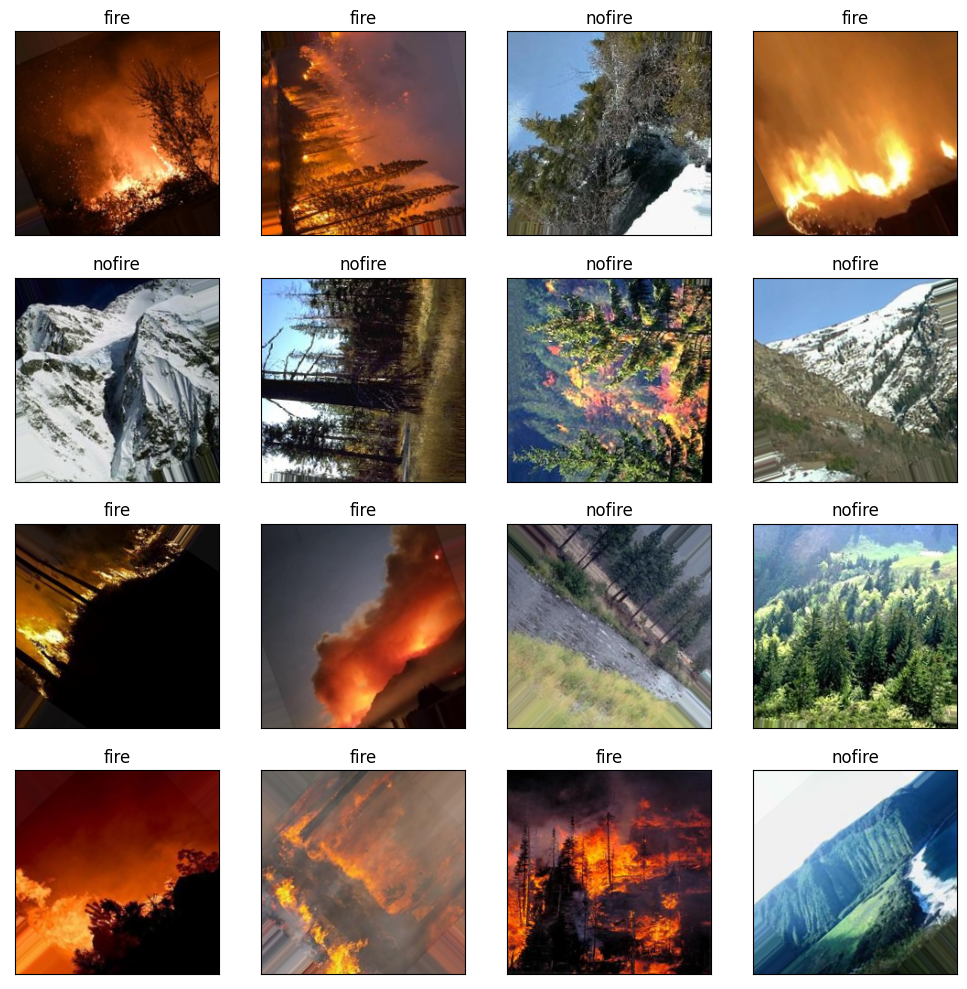

In [15]:
# Display 16 picture of the dataset with their labels
random_idx_gen = np.random.randint(low=0, high=len(train_images), size=16)
random_idx_batch = np.random.randint(low=0, high=32, size=16)

fig, axes = plt.subplots(
    nrows=4, 
    ncols=4, 
    figsize=(10, 10),
    subplot_kw={'xticks': [], 'yticks': []}
)

for i, ax in enumerate(axes.flat):
    image = (train_images[random_idx_gen[i]][0][random_idx_batch[i]] + 1.0) / 2.0
    label = np.argmax(train_images[random_idx_gen[i]][1][random_idx_batch[i]])
    label = labels[label]
    ax.imshow(image)
    ax.set_title(label)

plt.tight_layout()
plt.show()

# 🤹🚄 Training the model
The model images will be subjected to a pre-trained CNN model called MobileNetV2. Three callbacks will be utilized to monitor the training. These are: Model Checkpoint, Early Stopping, Tensorboard callback. The summary of the model hyperparameter is shown as follows:

- **Batch size** : 32

- **Epochs** : 100

- **Input Shape** : (250, 250, 3)

- **Output layer** : 2 neurons

In [15]:
# load the pre-trained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

model = tf.keras.Sequential([
    pretrained_model,
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(2, activation='softmax')
], name="model_based_on_mobilenetv2")

model.compile(
    optimizer=Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

9406464/9406464 [==============================] - 0s 0us/step


In [16]:
model.summary()

Model: "model_based_on_mobilenetv2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 2)                 514       
                                        

In [17]:
# Setup EarlyStopping callback to stop training if val_loss doesn't improve for 5 epochs
early_stopping = EarlyStopping(
    monitor="val_loss",       # watch the val loss metric
    patience=5,               # if val loss decreases for 5 epochs in a row, stops training
    restore_best_weights=True
)

In [18]:
history = model.fit_generator(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=30,
    callbacks=[early_stopping]
)

C:\Users\isabe\AppData\Local\Temp/ipykernel_5248/1139632790.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/30
67/67 [==============================] - 163s 2s/step - loss: 0.2306 - accuracy: 0.9037 - val_loss: 0.0479 - val_accuracy: 0.9868
Epoch 2/30
67/67 [==============================] - 139s 2s/step - loss: 0.0487 - accuracy: 0.9845 - val_loss: 0.0348 - val_accuracy: 0.9868
Epoch 3/30
67/67 [==============================] - 137s 2s/step - loss: 0.0405 - accuracy: 0.9883 - val_loss: 0.0221 - val_accuracy: 0.9934
Epoch 4/30
67/67 [==============================] - 142s 2s/step - loss: 0.0344 - accuracy: 0.9878 - val_loss: 0.0165 - val_accuracy: 0.9945
Epoch 5/30
67/67 [==============================] - 138s 2s/step - loss: 0.0224 - accuracy: 0.9930 - val_loss: 0.0202 - val_accuracy: 0.9912
Epoch 6/30
67/67 [==============================] - 138s 2s/step - loss: 0.0226 - accuracy: 0.9934 - val_loss: 0.0125 - val_accuracy: 0.9956
Epoch 7/30
67/67 [==============================] - 137s 2s/step - loss: 0.0211 - accuracy: 0.9906 - val_loss: 0.0143 - val_accuracy: 0.9967
Epoch 8/30
67

# 💾 Save & Load Trained Model

Aqui nós treinamos o modelo treinado, após 25 épocas, utilizando Pickle.

In [31]:
# saves/dumps trained model
with open('trained_model_isa.pkl', 'wb') as handle:
    pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('training_history_isa.pkl', 'wb') as handle:
    pickle.dump(history, handle, protocol=pickle.HIGHEST_PROTOCOL)

INFO:tensorflow:Assets written to: ram://ab0a3a7a-76f3-4379-9250-aee9baab451f/assets


INFO:tensorflow:Assets written to: ram://ab0a3a7a-76f3-4379-9250-aee9baab451f/assets


INFO:tensorflow:Assets written to: ram://fdc68d6f-17a4-4d51-97ef-2a3dd5c42afc/assets


INFO:tensorflow:Assets written to: ram://fdc68d6f-17a4-4d51-97ef-2a3dd5c42afc/assets


# ✔️Model Evaluation


Visualizing Loss curves.

Plotting the Classification Reports and Confusion Matrix.

In [19]:
_, y_val, y_true = make_predictions(model, val_images)
y_val, y_true = map_to_label(y_val, labels), map_to_label(y_true, labels)

val_loss, val_acc = model.evaluate(val_images)

Making predictions...
29/29 [==============================] - 41s 1s/step - loss: 0.0107 - accuracy: 0.9967


In [20]:
print(f'The first 5 predictions: {y_val[:5]}')
print("\n")
print(f'    Validation Loss: {val_loss:.5f}')
print(f'Validation Accuracy: {val_acc*100:.2f}%')
print("\n")
print("\tClassification Report for Validation Data")
print("-----------------------------------------------------")
print(classification_report(y_true, y_val))

The first 5 predictions: ['fire', 'fire', 'nofire', 'nofire', 'nofire']


    Validation Loss: 0.01066
Validation Accuracy: 99.67%


	Classification Report for Validation Data
-----------------------------------------------------
              precision    recall  f1-score   support

        fire       1.00      1.00      1.00       444
      nofire       1.00      1.00      1.00       468

    accuracy                           1.00       912
   macro avg       1.00      1.00      1.00       912
weighted avg       1.00      1.00      1.00       912



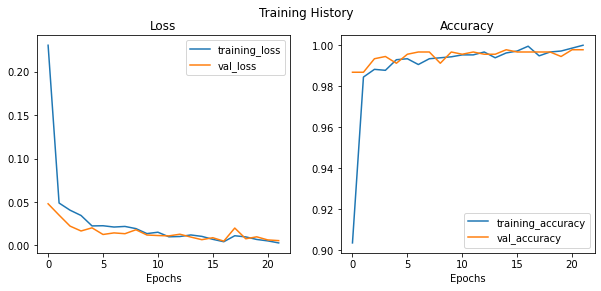

In [21]:
plot_history(history)

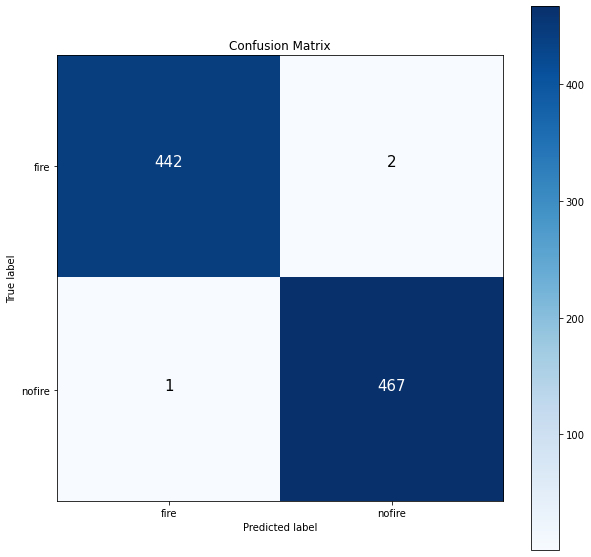

In [22]:
make_confusion_matrix(y_true, y_val, list(labels.values()))

Como se pode observar, nossa acurácia nos dados de validação foi de 100%, o que é espantoso, tendo em vista que utilizamos o modelo sem realizar nenhuma alteração significativa nele. Tendo isso em vista, podemos observar o poder adaptativo do transfer learning, que com poucas iterações já obteve uma enorme acurácia no treino e validação. Além disso, o número de imagens utilizado parece ser o suficiente para treinar nossa rede, pelo sucesso obtido no teste.

Entretanto, pelo enorme sucesso do modelo em sua tarefa, levantou-se o questionamento se nosso problema não é simples demais, se por termos utilizado uma base de dados "limpa" (sem pessoas, máquinas e outras coisas que não fazem parte do problema) não facilitamos em excesso o estudo. Sendo assim, é possível que nossa base de dados não seja representativa da realidade, e nosso modelo, apesar de estar funcionando muito bem no teste, ser insuficiente na 'vida real'.

Assim, nosso próximo passo é pensar em como aumentar a complexidade de nossa base de dados para obtermos um modelo mais representativo da realidade. Uma forma de se obter isso seria aumentar nossa base de dados com outros dados não tão "limpos".

# Test model with weird images

In [23]:
weird_images_path = Path("../weird-images")

In [24]:
weird_images_df = create_images_dataframe(weird_images_path)

weird_images_df.head()

Filepath Label
0  ..\weird-images\fire\299823-arvore-isolada-em-...  fire
1  ..\weird-images\fire\594081262c48f35264faf6f10...  fire
2  ..\weird-images\fire\624db831-5394-419a-b783-2...  fire
3  ..\weird-images\fire\299823-arvore-isolada-em-...  fire
4  ..\weird-images\fire\594081262c48f35264faf6f10...  fire

In [25]:
weird_image_generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,)

weird_images = weird_image_generator.flow_from_dataframe(
    dataframe=weird_images_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    rescale=1./255,
    color_mode='rgb',
    shuffle=True,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    subset='training'
)

Found 17 validated image filenames belonging to 2 classes.


In [26]:
weird_X, y_pred, y_true = make_predictions(model, weird_images)
y_pred, y_true = map_to_label(y_pred, labels), map_to_label(y_true, labels)

Making predictions...
1/1 [==============================] - 1s 558ms/step


In [27]:
print("\tClassification Report for Validation Data")
print("-----------------------------------------------------")
print(classification_report(y_true, y_pred))

	Classification Report for Validation Data
-----------------------------------------------------
              precision    recall  f1-score   support

        fire       0.88      0.50      0.64        14
      nofire       0.22      0.67      0.33         3

    accuracy                           0.53        17
   macro avg       0.55      0.58      0.48        17
weighted avg       0.76      0.53      0.58        17



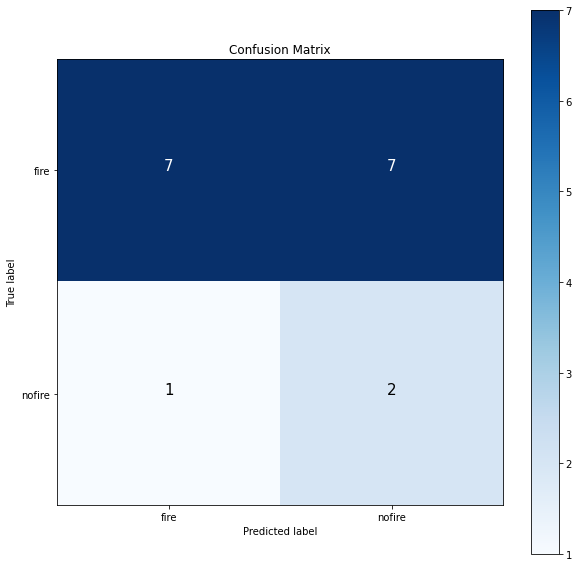

In [28]:
make_confusion_matrix(y_true, y_pred, list(labels.values()))

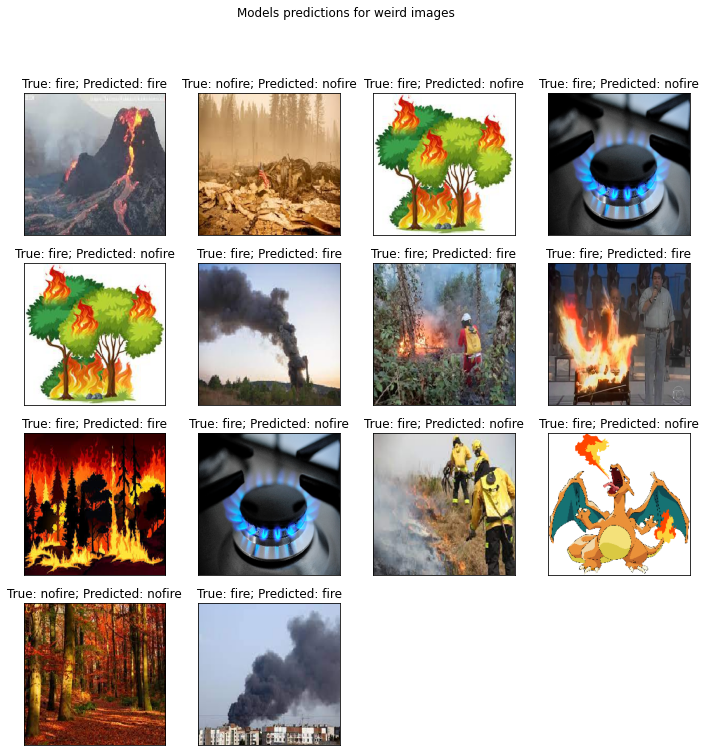

In [29]:
rows, cols = 4, 4
fig = plt.figure(figsize=(12, 12))
fig.suptitle("Models predictions for weird images")

for i in range(14):
    image = (weird_X[i]+1.0)/2.0
    fig.add_subplot(rows, cols, i+1)
    plt.title(f'True: {y_true[i]}; Predicted: {y_pred[i]}')
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    
plt.show()

### https://stackoverflow.com/questions/72426971/dataset-size-after-data-augmentation

## New dataset test

In [33]:
def create_labels_dataframe(path):
    # Get filepaths and labels
    filepaths = list(path.glob(r'**/*.txt'))
    
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
    
    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    return pd.concat([filepaths, labels], axis=1)

In [52]:
def create_images_dataframe2(path):
    # Get filepaths and labels
    filepaths = list(path.glob(r'**/*.JPG'))
    
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
    
    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    return pd.concat([filepaths, labels], axis=1)

In [40]:
def convert_txt_label(path_labels, imagepath):
    image = imagepath.split('\\')[-1]
    isempty = os.stat(str(path_labels)+"\\"+str(image)).st_size
    if isempty == 0:
        return 0
    else:
        return 1

def create_labels_dfire(path_labels):
    df = create_labels_dataframe(path_labels)
    df['labels'] = df['Filepath'].apply(lambda x: convert_txt_label(path_labels, x))
    df = df[['Filepath', 'labels']]
    df = df.rename(columns={'labels':'Label'})
    return df

In [43]:
path_labels = Path("../D-fire/test/labels/")
df_labels = create_labels_dfire(path_labels)

In [58]:
path_images = Path("../D-fire/test/images")
df_images = create_images_dataframe2(path_images)

In [59]:
df_images['Label'] = df_labels['Label'] 

def label_c(x):
    if x == 0:
        return "nofire"
    else:
        return "fire"

df_images['Label'] = df_images['Label'].apply(lambda x: label_c(x)) # --- 0 = nofire ; 1 = fire ---

In [60]:
df_images

Filepath   Label
0     ..\D-fire\test\images\AoF06723.jpg  nofire
1     ..\D-fire\test\images\AoF06724.jpg  nofire
2     ..\D-fire\test\images\AoF06725.jpg  nofire
3     ..\D-fire\test\images\AoF06726.jpg  nofire
4     ..\D-fire\test\images\AoF06727.jpg  nofire
...                                  ...     ...
4301  ..\D-fire\test\images\WEB11802.jpg    fire
4302  ..\D-fire\test\images\WEB11803.jpg    fire
4303  ..\D-fire\test\images\WEB11804.jpg    fire
4304  ..\D-fire\test\images\WEB11805.jpg    fire
4305  ..\D-fire\test\images\WEB11806.jpg    fire

[4306 rows x 2 columns]

In [61]:
dfire_image_generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,)

dfire_images = dfire_image_generator.flow_from_dataframe(
    dataframe=df_images,
    x_col='Filepath',
    y_col='Label',
    #target_size=(224, 224),
    rescale=1./255,
    color_mode='rgb',
    shuffle=True,
    class_mode='categorical'
)

Found 4306 validated image filenames belonging to 2 classes.


In [62]:
dfire_X, y_pred, y_true = make_predictions(model, dfire_images)
y_pred, y_true = map_to_label(y_pred, labels), map_to_label(y_true, labels)

Making predictions...
135/135 [==============================] - 176s 1s/step


In [63]:
print("\tClassification Report for Validation Data")
print("-----------------------------------------------------")
print(classification_report(y_true, y_pred))

	Classification Report for Validation Data
-----------------------------------------------------
              precision    recall  f1-score   support

        fire       0.70      0.60      0.65      2301
      nofire       0.60      0.70      0.65      2005

    accuracy                           0.65      4306
   macro avg       0.65      0.65      0.65      4306
weighted avg       0.65      0.65      0.65      4306



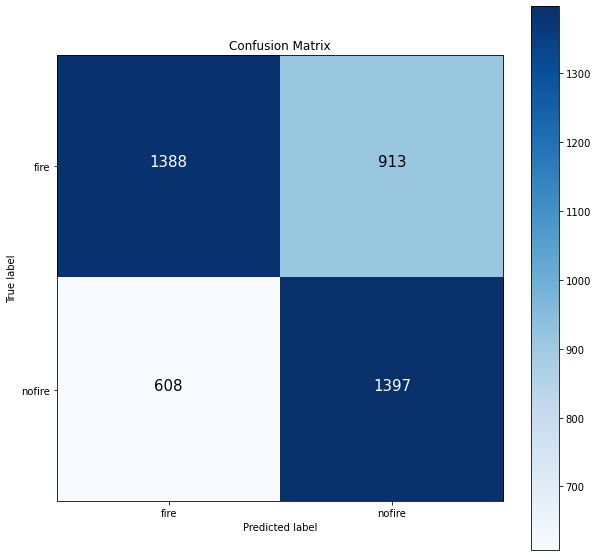

In [64]:
make_confusion_matrix(y_true, y_pred, list(labels.values()))

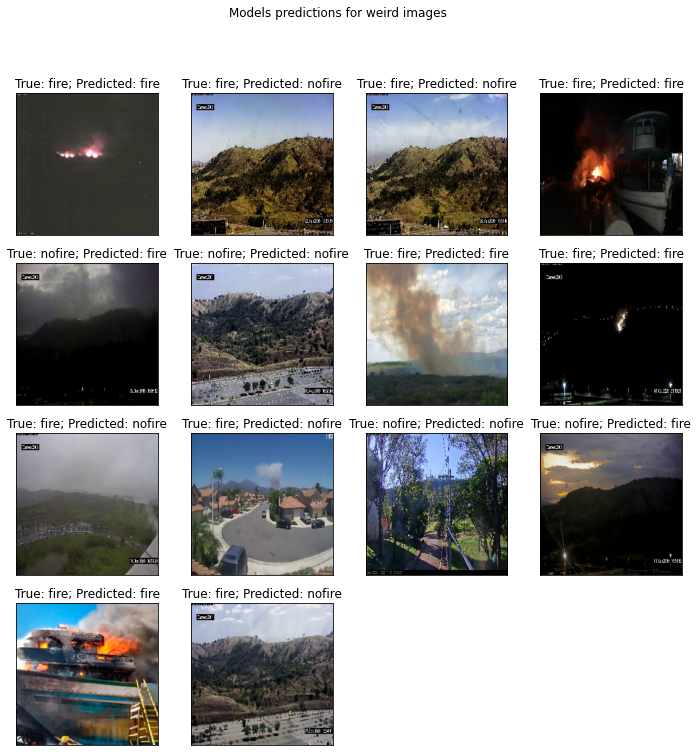

In [65]:
rows, cols = 4, 4
fig = plt.figure(figsize=(12, 12))
fig.suptitle("Models predictions for weird images")

for i in range(14):
    image = (dfire_X[i]+1.0)/2.0
    fig.add_subplot(rows, cols, i+1)
    plt.title(f'True: {y_true[i]}; Predicted: {y_pred[i]}')
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    
plt.show()

## Retreinando no novo dataset

In [87]:
path_labels = Path("../D-fire/train/labels/")
df_labels = create_labels_dfire(path_labels)

path_images = Path("../D-fire/train/images")
df_images = create_images_dataframe2(path_images)

df_images['Label'] = df_labels['Label'] 
df_images['Label'] = df_images['Label'].apply(lambda x: label_c(x))

In [88]:
BATCH_SIZE = 32

In [89]:
# shuffles dataframe rows

df_images = df_images.sample(frac=1).reset_index(drop=True)

In [90]:
train_image_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.3,
    rotation_range=90,
    horizontal_flip=True
)

train_images = train_image_generator.flow_from_dataframe(
    dataframe=df_images,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    rescale=1./255,
    color_mode='rgb',
    shuffle=True,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    subset='training'
)

val_images = train_image_generator.flow_from_dataframe(
    dataframe=df_images,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    rescale=1./255,
    color_mode='rgb',
    shuffle=True,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    subset='validation'
)

Found 12055 validated image filenames belonging to 2 classes.
Found 5166 validated image filenames belonging to 2 classes.


In [91]:
# load the pre-trained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

model = tf.keras.Sequential([
    pretrained_model,
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(2, activation='softmax')
], name="model_based_on_mobilenetv2")

model.compile(
    optimizer=Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [92]:
# Setup EarlyStopping callback to stop training if val_loss doesn't improve for 5 epochs
early_stopping = EarlyStopping(
    monitor="val_loss",       # watch the val loss metric
    patience=5,               # if val loss decreases for 5 epochs in a row, stops training
    restore_best_weights=True
)

In [93]:
history = model.fit_generator(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=30,
    callbacks=[early_stopping]
)

C:\Users\isabe\AppData\Local\Temp/ipykernel_5248/1139632790.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/30
377/377 [==============================] - 619s 2s/step - loss: 0.5626 - accuracy: 0.6968 - val_loss: 0.4496 - val_accuracy: 0.7855
Epoch 2/30
377/377 [==============================] - 568s 2s/step - loss: 0.4550 - accuracy: 0.7740 - val_loss: 0.4052 - val_accuracy: 0.8118
Epoch 3/30
377/377 [==============================] - 567s 2s/step - loss: 0.4173 - accuracy: 0.7954 - val_loss: 0.3751 - val_accuracy: 0.8275
Epoch 4/30
377/377 [==============================] - 568s 2s/step - loss: 0.3882 - accuracy: 0.8171 - val_loss: 0.3576 - val_accuracy: 0.8376
Epoch 5/30
377/377 [==============================] - 567s 2s/step - loss: 0.3615 - accuracy: 0.8310 - val_loss: 0.3391 - val_accuracy: 0.8511
Epoch 6/30
377/377 [==============================] - 569s 2s/step - loss: 0.3503 - accuracy: 0.8399 - val_loss: 0.3418 - val_accuracy: 0.8448
Epoch 7/30
377/377 [==============================] - 567s 2s/step - loss: 0.3369 - accuracy: 0.8455 - val_loss: 0.3168 - val_accuracy: 0.8620

In [94]:
# saves/dumps trained model
with open('trained_model_dfire.pkl', 'wb') as handle:
    pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('training_history_dfire.pkl', 'wb') as handle:
    pickle.dump(history, handle, protocol=pickle.HIGHEST_PROTOCOL)

INFO:tensorflow:Assets written to: ram://4a815b78-079e-4595-8808-f349c79af1de/assets


INFO:tensorflow:Assets written to: ram://4a815b78-079e-4595-8808-f349c79af1de/assets


INFO:tensorflow:Assets written to: ram://6b3664e2-16b5-4acb-810c-e1a24e5a5f12/assets


INFO:tensorflow:Assets written to: ram://6b3664e2-16b5-4acb-810c-e1a24e5a5f12/assets


In [95]:
_, y_val, y_true = make_predictions(model, val_images)
y_val, y_true = map_to_label(y_val, labels), map_to_label(y_true, labels)

val_loss, val_acc = model.evaluate(val_images)

Making predictions...
162/162 [==============================] - 172s 1s/step - loss: 0.2662 - accuracy: 0.8842


In [96]:
print(f'The first 5 predictions: {y_val[:5]}')
print("\n")
print(f'    Validation Loss: {val_loss:.5f}')
print(f'Validation Accuracy: {val_acc*100:.2f}%')
print("\n")
print("\tClassification Report for Validation Data")
print("-----------------------------------------------------")
print(classification_report(y_true, y_val))

The first 5 predictions: ['fire', 'fire', 'nofire', 'fire', 'nofire']


    Validation Loss: 0.26619
Validation Accuracy: 88.42%


	Classification Report for Validation Data
-----------------------------------------------------
              precision    recall  f1-score   support

        fire       0.88      0.91      0.90      2869
      nofire       0.89      0.85      0.87      2297

    accuracy                           0.89      5166
   macro avg       0.89      0.88      0.88      5166
weighted avg       0.89      0.89      0.89      5166



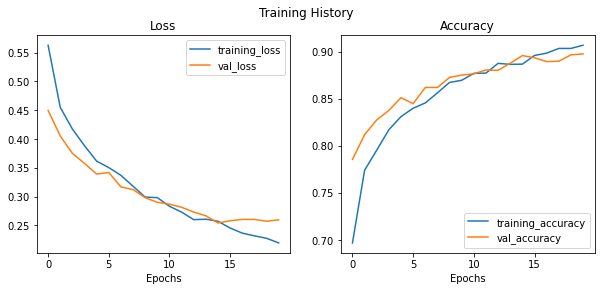

In [97]:
plot_history(history)

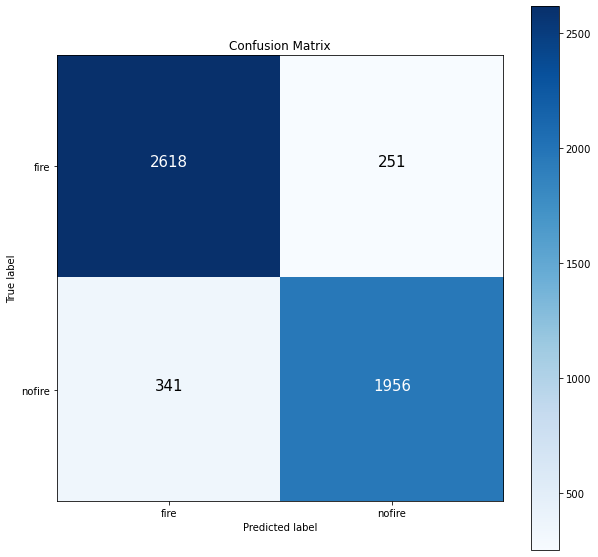

In [98]:
make_confusion_matrix(y_true, y_val, list(labels.values()))